In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir(f'/home/{user}/codes/MotionBERT')
import scipy.io

root_3dhp = f'/home/{user}/Datasets/HAAI/3DHP'
source = 'original' # s
root_original = os.path.join(root_3dhp, source)
train_folder = os.path.join(root_original, 'train')
test_folder = os.path.join(root_original, 'test')

In [3]:
# get test data
data_dict, cam_params = load_3dhp_original('test')

TS1 (6151, 17, 2) (6151, 17, 3) (6151,)
TS2 (6080, 17, 2) (6080, 17, 3) (6080,)
TS3 (5838, 17, 2) (5838, 17, 3) (5838,)
TS4 (6007, 17, 2) (6007, 17, 3) (6007,)
TS5 (320, 17, 2) (320, 17, 3) (320,)
TS6 (492, 17, 2) (492, 17, 3) (492,)


In [4]:
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_test_canonical_3d_with_fixed_dist_5_pkl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

for subject in os.listdir(test_folder):
    if 'TS' not in subject:
        continue
    file_name = subject + '.pkl'
    save_path = os.path.join(save_folder, file_name)
    # if os.path.exists(save_path):
    #     print(f'{file_name} already exists')
    #     continue

    data = {}
    for key in ['joint_2d', 'joint_2d_from_canonical_3d', 'confidence', 'camera_name', 'action', 'source', 'frame', 'cam_3d', 'cam_3d_from_canonical_3d', 'cam_param']:
        data[key] = []
        
    cam_param = cam_params[subject]
    C = cam_params[subject]['C']
    R = cam_params[subject]['R']
    t = cam_params[subject]['t']
    intrinsic = cam_params[subject]['intrinsic']
    extrinsic = cam_params[subject]['extrinsic']
    H, W = cam_params[subject]['H'], cam_params[subject]['W']
    fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

    source = subject
    action = subject
    camera_id = subject
    
    img_2d = data_dict[subject]['annot2']
    cam_3d = data_dict[subject]['annot3']/1000
    cam_3d_from_canonical_3d = cam_3d.copy()
    cam_3d_from_canonical_3d[...,:2] -= cam_3d[:, 0:1, :2]
    cam_3d_from_canonical_3d[..., 2] -= cam_3d[:, 0:1, 2] 
    cam_3d_from_canonical_3d[..., 2] += 5
    img_2d_from_canonical_3d = np.einsum('ij,jkl->ikl', intrinsic, cam_3d_from_canonical_3d.T).T
    img_2d_from_canonical_3d = img_2d_from_canonical_3d / img_2d_from_canonical_3d[..., 2:3]


    # store
    data['joint_2d'] = list(img_2d)
    data['joint_2d_from_canonical_3d'] = list(img_2d_from_canonical_3d)
    data['confidence'] = np.ones([len(img_2d), 17, 1])
    #data['joint3d_image'].append(np.array(img_3d).copy()) 
    #data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
    #data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
    data['camera_name'] = [camera_id] * len(img_2d)
    data['action'] = [action] * len(img_2d)
    data['source'] = [source] * len(img_2d)
    data['frame'] = list(range(len(img_2d)))
    data['cam_3d'] = list(cam_3d)
    data['cam_3d_from_canonical_3d'] = list(cam_3d_from_canonical_3d)
    data['cam_param'] = [cam_param] * len(img_2d)

    
    savepkl(data, save_path)
    #break

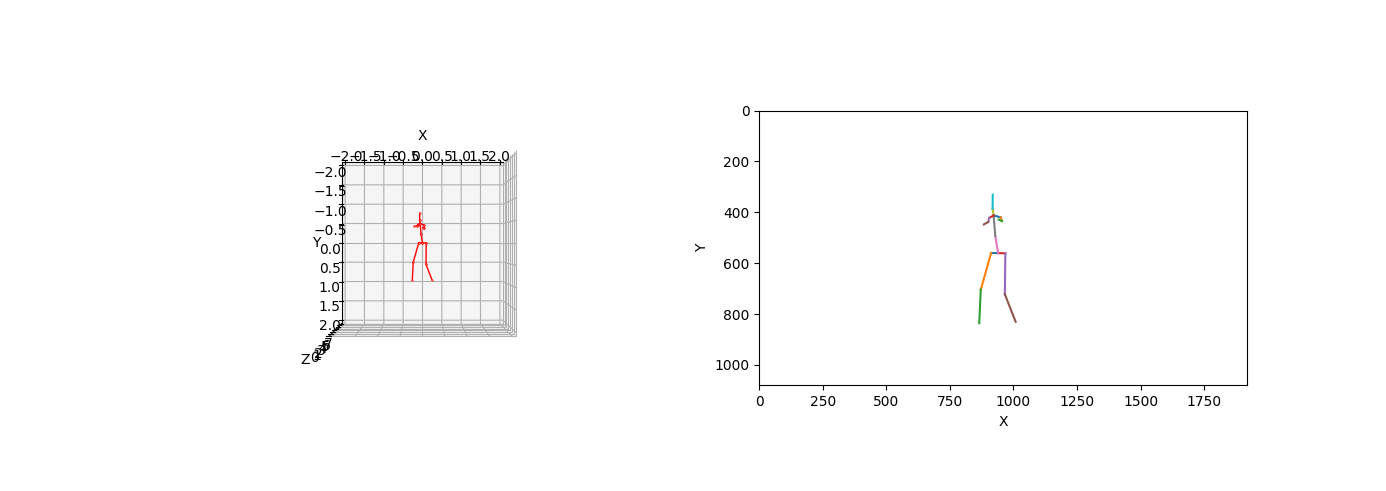

In [12]:
frame_num = 300
cam_3d = np.array(data['cam_3d'])[frame_num]
cam_3d_hat = cam_3d - cam_3d[0]
cam_3d_from_canonical_3d = np.array(data['cam_3d_from_canonical_3d'])[frame_num]
joint_2d_from_canonical_3d = np.array(data['joint_2d_from_canonical_3d'])[frame_num]
cam_param = data['cam_param'][frame_num]
W, H = cam_param['W'], cam_param['H']

%matplotlib widget
fig = plt.figure(0)
fig.clear()
ax_cam = axes_3d(fig, loc=121, view=(-90,-90), zlim=(0, 7))
#draw_3d_pose(ax, img_3d_hat/1000)
draw_3d_pose(ax_cam, cam_3d_hat, color='r')
ax_2d = axes_2d(fig, loc=122, W=W, H=H)
draw_2d_pose(ax_2d, joint_2d_from_canonical_3d)
plt.show()